# Build  spectra for AuxTel with new spectractor (September 2021): Part 1

# For processing September 09 Planetary Nebula

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- cretion date : September 22th  2021
- version v3


**This notebook is to help for finding the position of order 0 of the target**

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and anaconda3_auxtel_v2 (no libradtran)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from iminuit import Minuit
import iminuit

In [3]:
iminuit.__version__

'2.7.0'

In [4]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [5]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [6]:
from astropy.visualization import simple_norm

# Path

In [7]:
HOSTCC=False

In [8]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/2021-09-09")
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/softs/github/lsst/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/2021-09-09")

# Function

In [9]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [10]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

# Logbook for file selection

In [11]:
filename_logbook='logbooks/auxtelholologbook_PNG_2021_09_09_v2.0.csv'

In [12]:
df=pd.read_csv(filename_logbook,index_col=0)

In [13]:
pd.set_option('display.max_rows', None)

In [14]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-09-09T23:53:55.100,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000165_...,165,PNG321.0+03.9,empty_1,holo4_003,1.380357,10.0,...,9.2,16.0,4.0,300.0,1750.0,NaN,NaN,,1.0,1.0
1,1,2021-09-09T23:54:18.095,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000166_...,166,PNG321.0+03.9,empty_1,holo4_003,1.381613,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
2,2,2021-09-09T23:54:41.122,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000167_...,167,PNG321.0+03.9,empty_1,holo4_003,1.382874,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
3,3,2021-09-09T23:55:04.180,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000168_...,168,PNG321.0+03.9,empty_1,holo4_003,1.384148,30.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
4,4,2021-09-09T23:55:47.196,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000169_...,169,PNG321.0+03.9,empty_1,holo4_003,1.386523,30.0,...,9.0,17.0,3.1,300.0,1750.0,NaN,NaN,,1.0,1.0
5,5,2021-09-09T23:56:30.224,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000170_...,170,PNG321.0+03.9,empty_1,holo4_003,1.388908,30.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
6,6,2021-09-09T23:57:13.142,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000171_...,171,PNG321.0+03.9,empty_1,holo4_003,1.391300,60.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
7,7,2021-09-10T00:04:18.230,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000174_...,174,PNG321.0+03.9,empty_1,holo4_003,1.415803,0.0,...,8.9,15.0,3.7,300.0,1750.0,NaN,NaN,,1.0,1.0
8,8,2021-09-10T00:06:01.239,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000175_...,175,PNG321.0+03.9,empty_1,holo4_003,1.421962,60.0,...,8.9,15.0,3.8,300.0,1750.0,NaN,NaN,,1.0,1.0
9,9,2021-09-10T00:07:14.156,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000176_...,176,PNG321.0+03.9,empty_1,holo4_003,1.426365,60.0,...,8.9,15.0,4.4,300.0,1750.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [15]:
idx=10

In [16]:
myhome=os.getenv("HOME")

In [17]:
dir_images=path_images

In [18]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

In [19]:
file_target(filename_image)

'PNG321.0+03.9'

## Configuration file 

Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [20]:
filename=os.path.join(dir_images,filename_image)
output_directory="./outputs_process_holo_PNG"
output_figures="figures_process_holo_PNG"
guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)
# standard configuration
# config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY (dispersion rotation angle)
config="./config/auxtel_PNG.ini"

target = file_target(filename_image)[0]

In [21]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)

# Configuration of the running mode

In [22]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [23]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

- adaptation to Spectractor (master branch) for Auxtel

In [24]:
from shutil import copyfile

In [25]:
copyfile(filename,filename_image)

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

In [26]:
from astropy.io import fits

In [27]:
hdu = fits.open(filename_image)

In [28]:
hdu.info()

Filename: holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [29]:
header=hdu[0].header
image=hdu[0].data

In [30]:
hdu.close()

## Rotate the image as expected by Spectractor

In [31]:
rot_image=np.flip(np.flip(image, 1), 0)

In [32]:
# Create an ImageNormalize object
# norm = simple_norm(image, 'log')

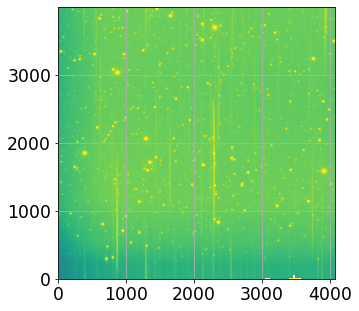

In [33]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)
ax.imshow(rot_image,origin="lower",norm=LogNorm(0.1,1000))
ax.grid()
plt.show()

### Remove WCS

In [34]:
del header['WCSAXES']
del header['CTYPE1']
del header['CTYPE2']
del header['CUNIT1']
del header['CUNIT2']
del header['CRVAL1']
del header['CRVAL2']
del header['CRPIX1']
del header['CRPIX2']

## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [35]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [36]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [37]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     114   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [38]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new file

In [39]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

/users/dagoret/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## Show relevant parameters

In [40]:
parameters.OBS_NAME

'AUXTEL'

In [41]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [42]:
parameters.DISTANCE2CCD

182.0

In [43]:
parameters.LAMBDA_MIN 

300

In [44]:
parameters.LAMBDA_MAX 

1100

In [45]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [46]:
image.filter_label

''

In [47]:
image.header["FILTER"]

'empty_1'

In [48]:
#image.header

# Plot image and find the target position

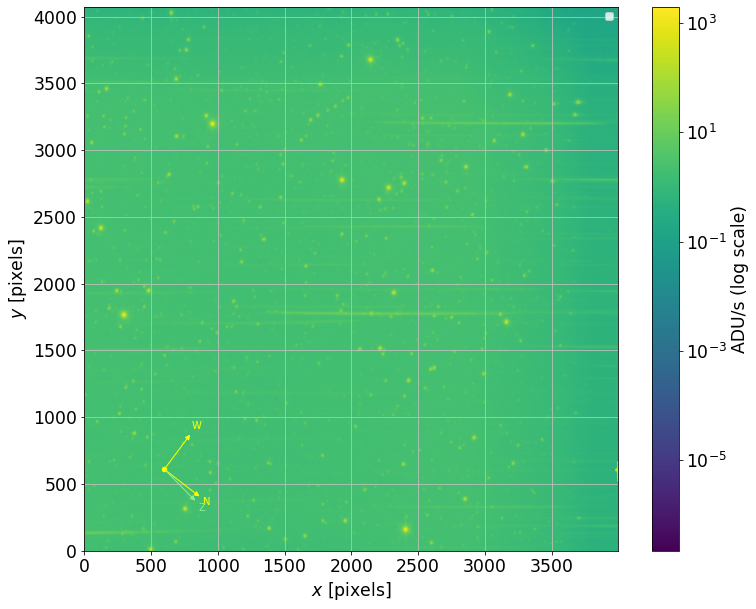

In [49]:
image.plot_image(figsize=(12, 10),scale="log")

In [50]:
filename_image

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

In [51]:

guess = [300., 1750.] # filename_image=df['file'][0] , holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits

In [52]:
filename_image

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

2021-09-23 12:09:58  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                  c0_1        
    ------------------ ---------------------- --------------------
    2.4117157028579106 -0.0005479253587689358 0.001852009125744938
2021-09-23 12:09:58  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 5 iterations because the relative change of cost is below ftol=1.25e-05.


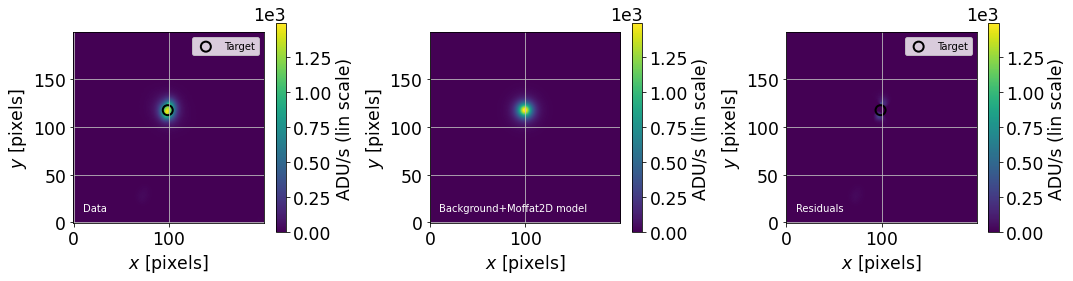

2021-09-23 12:09:59  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=5e-05.


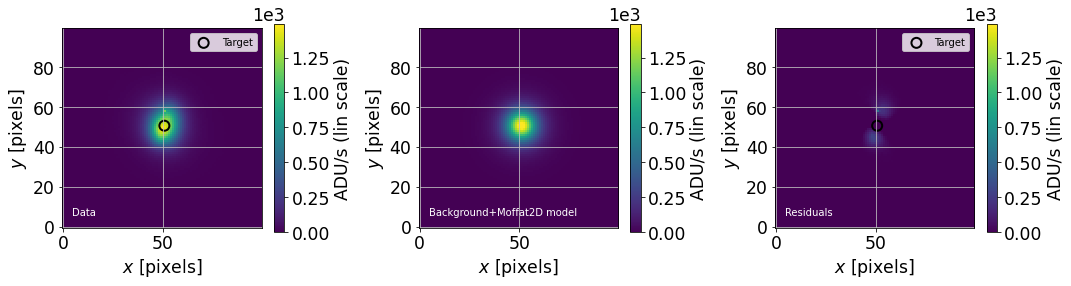

In [53]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [54]:
print(x1,y1)

298.7572132470918 1767.716480316109


In [55]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [56]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [57]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [58]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [59]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [60]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [61]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [62]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [63]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [64]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [65]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [66]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [67]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.05, 0.2, 'normal  : p_test   = 0.000e+00\n             : p_test_x = 2.234e-34\n             : p_test_y = 4.769e-29')

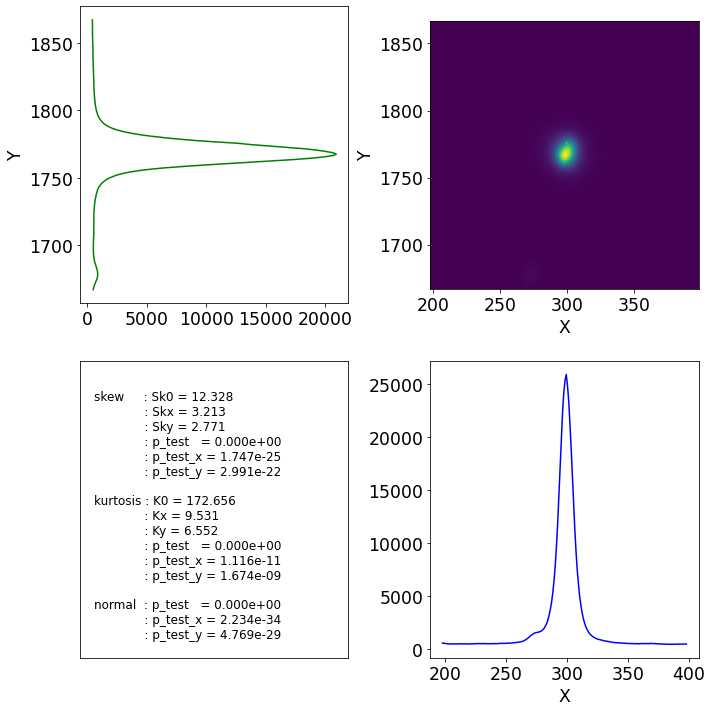

In [68]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)

# Go for spectrum reconstruction

2021-09-23 12:10:01  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-09-23 12:10:01  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits...
2021-09-23 12:10:01  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-09-23 12:10:01  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-09-23 12:10:01  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-09-23 12:10:01  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-09-23 12:10:07  Star       load                 INFO   
	Simbad:
  MAIN_ID          RA           DEC      ... Z_VALUE_2  SCRIPT_NUMBER_ID
                "h:m:s"       "d:m:s"    ...                            
------------ ------------- ------------- ... ---------- ----------------
WRAY 15-1269 14 59 53.4814 -54 18 07.524 ... -0.0002100                1
/users/dagoret/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA functio

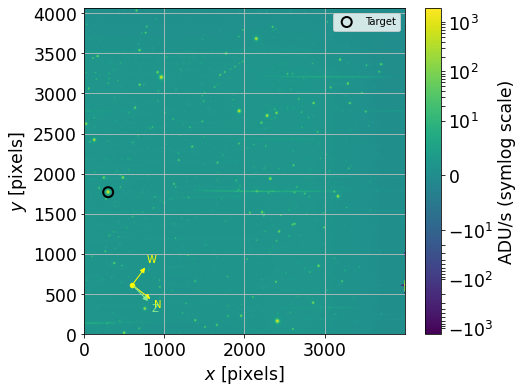

2021-09-23 12:10:11  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 298.75721325 1767.71648032]...
2021-09-23 12:10:11  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                  c1_0                   c0_1        
    ------------------ ----------------------- ---------------------
    2.5779062782682445 -0.00044648651864629476 6.713358537870236e-05
2021-09-23 12:10:11  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 5 iterations because the relative change of cost is below ftol=1.25e-05.


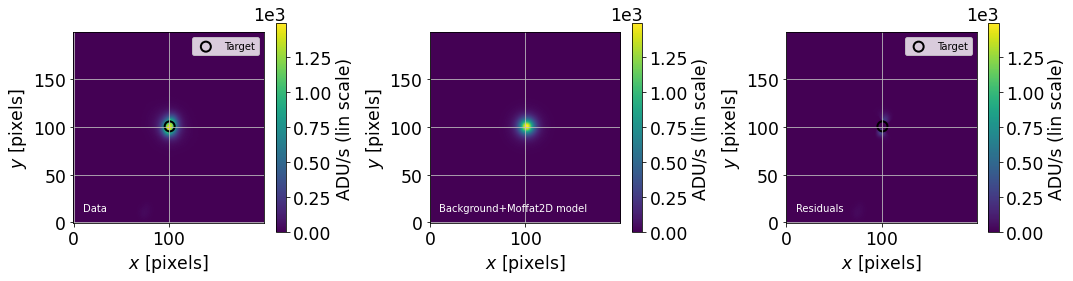

2021-09-23 12:10:12  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=5e-05.


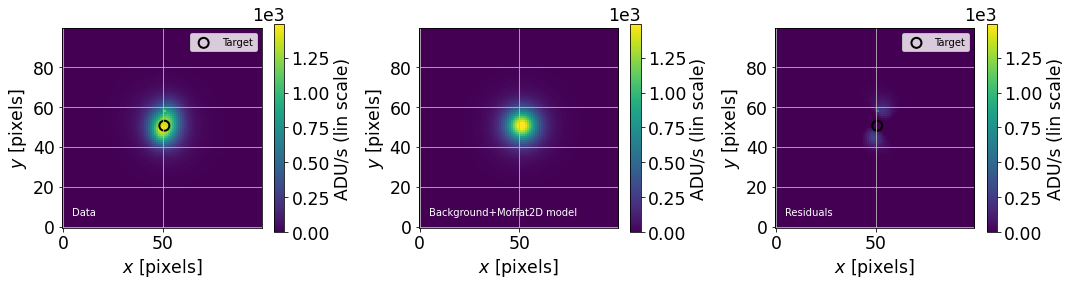

2021-09-23 12:10:13  Image      find_target          INFO   
	X,Y target position in pixels: 298.757,1767.719
2021-09-23 12:10:13  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


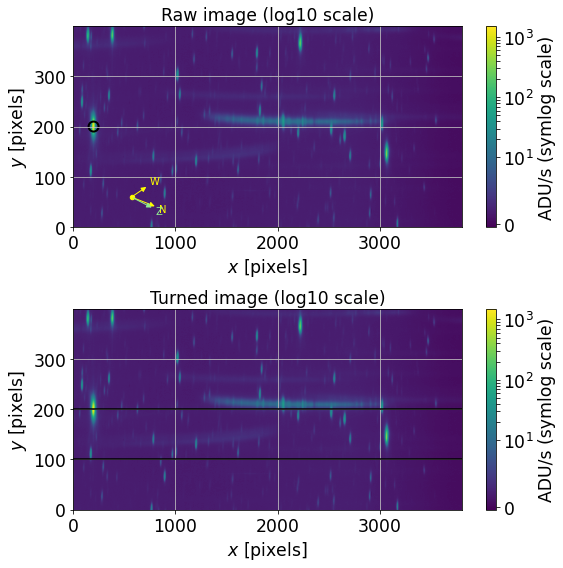

2021-09-23 12:10:25  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-09-23 12:10:25  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                  c0_1         
    ----------------- -------------------- ----------------------
    3.766939449482078 0.004251143443625793 -0.0005913148429287658
2021-09-23 12:10:25  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=5e-05.


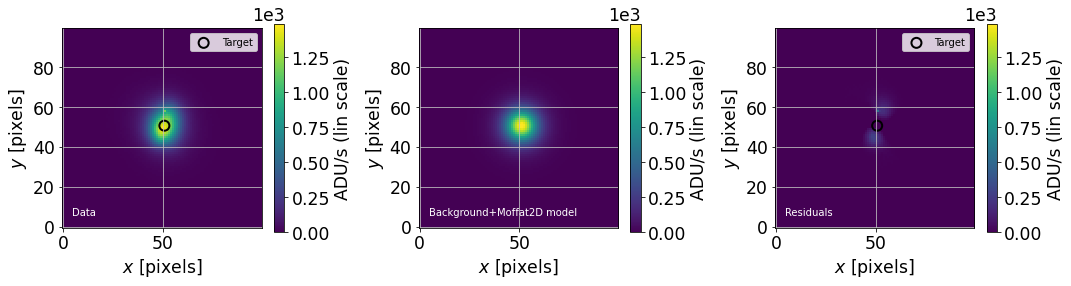

2021-09-23 12:10:26  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0002.


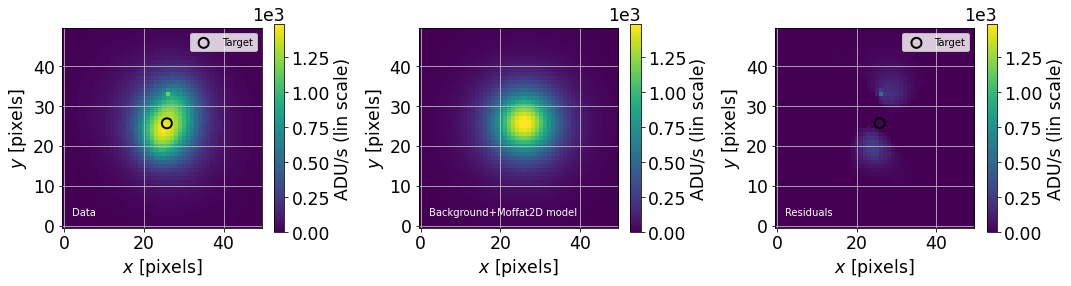

2021-09-23 12:10:27  Image      find_target          INFO   
	X,Y target position in pixels: 298.758,1767.718
2021-09-23 12:10:27  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-09-23 12:10:27  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 60 to 80 pixels
2021-09-23 12:10:27  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [1151:3468,1687:1847] (size (2317, 160))


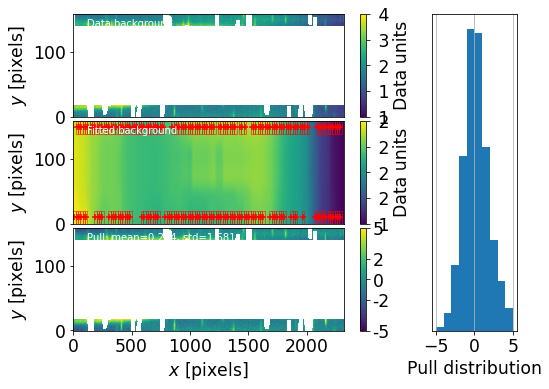

2021-09-23 12:10:29  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Pull distribution of background residuals differs too much from mean=0 and std=1. 
		mean=0.274; std=1.68
	These value should be smaller in absolute value than 0.5 and 1.3. 
	To do so, parameters.PIXWIDTH_BOXSIZE is divided by 2 from 20 -> 10.


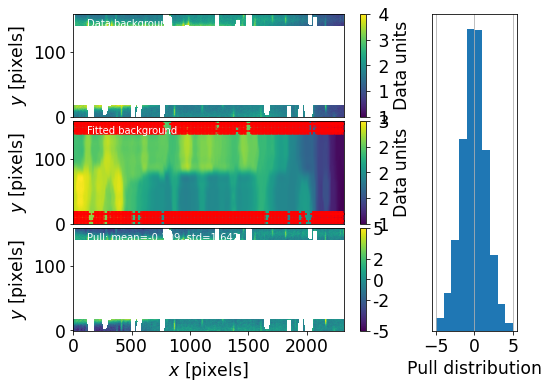

2021-09-23 12:10:34  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Pull distribution of background residuals differs too much from mean=0 and std=1. 
		mean=-0.109; std=1.64
	These value should be smaller in absolute value than 0.5 and 1.3. 
	To do so, parameters.PIXWIDTH_BOXSIZE is divided by 2 from 10 -> 5.


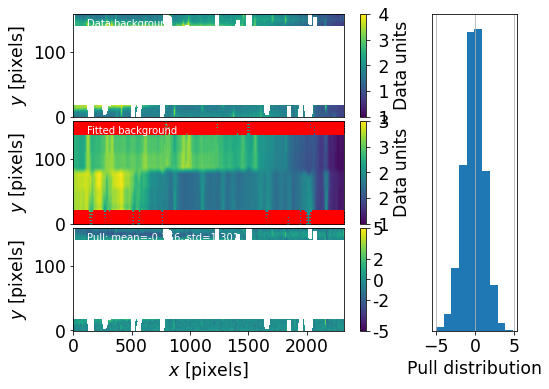

2021-09-23 12:10:47  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/psf.py:562: RuntimeWarning: invalid value encountered in true_divide
  out = evaluate_moffat1d_unnormalized(y, amplitude, y_c, gamma, alpha) / norm
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/psf.py:562: RuntimeWarning: divide by zero encountered in true_divide
  out = evaluate_moffat1d_unnormalized(y, amplitude, y_c, gamma, alpha) / norm
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1256: RuntimeWarning: invalid value encountered in subtract
  a = x[imax + np.argmin(np.abs(y[imax:] - 0.9 * maximum))]
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1257: RuntimeWarning: invalid value encountered in subtract
 

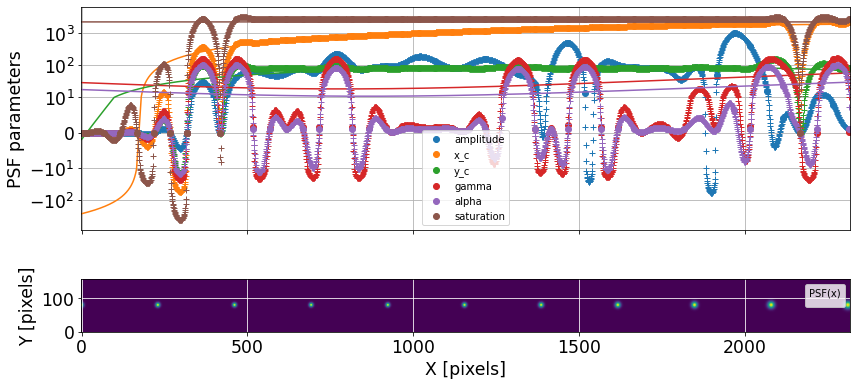

2021-09-23 12:10:53  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=2.7739e+06 initial chisq_red=29.929
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [  1.98097654  -0.22823945  -0.42445934   3.62859706  -7.37132381
   4.02777848 -12.180262    18.46193227  -4.9736051 ]
	New parameters: [  8.33725714 -10.34665396   8.71021734  53.20638861 -80.06036212
  57.70723171  12.2598756  -20.78128667  18.13456923]
	Final cost=1.6802e+06 final chisq_red=18.129 computed in 1.60s
2021-09-23 12:10:55  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.6802e+06 initial chisq_red=18.129
		 Line search: alpha_min=1.62 iter=1 funcalls=5
	Parameter shifts: [  1.92215865   3.34222448  -8.2974579   -4.02809687  19.37765904
 -11.21808136   4.7697218   -6.62108408   7.06998023]
	New parameters: [ 10.25941579  -7.00442947   0.41275944  49.17829174 -60.68270308
  46.48915035  17.0295974  -27.40237075  25.20454946]
	Final cost=1.092

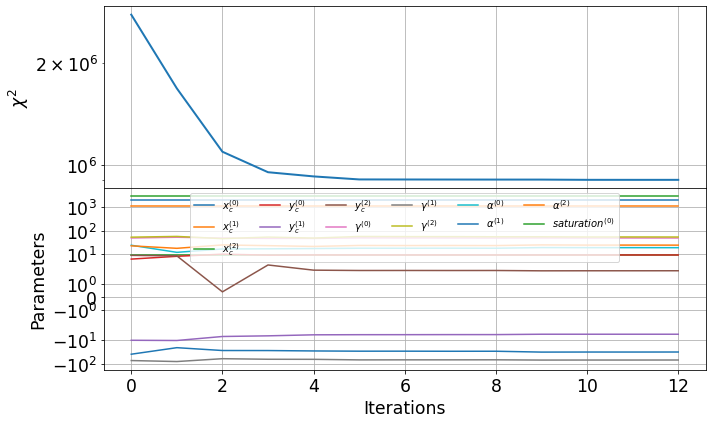

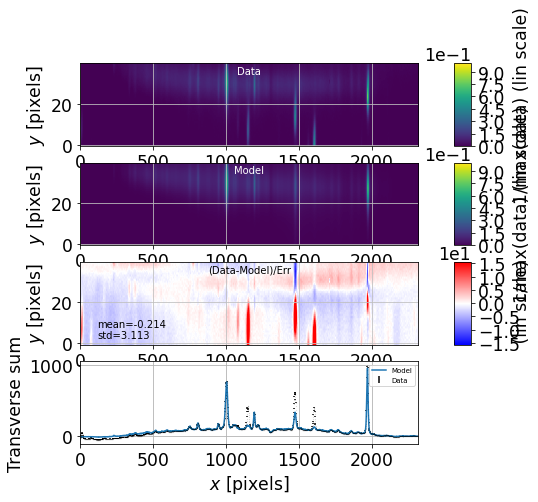

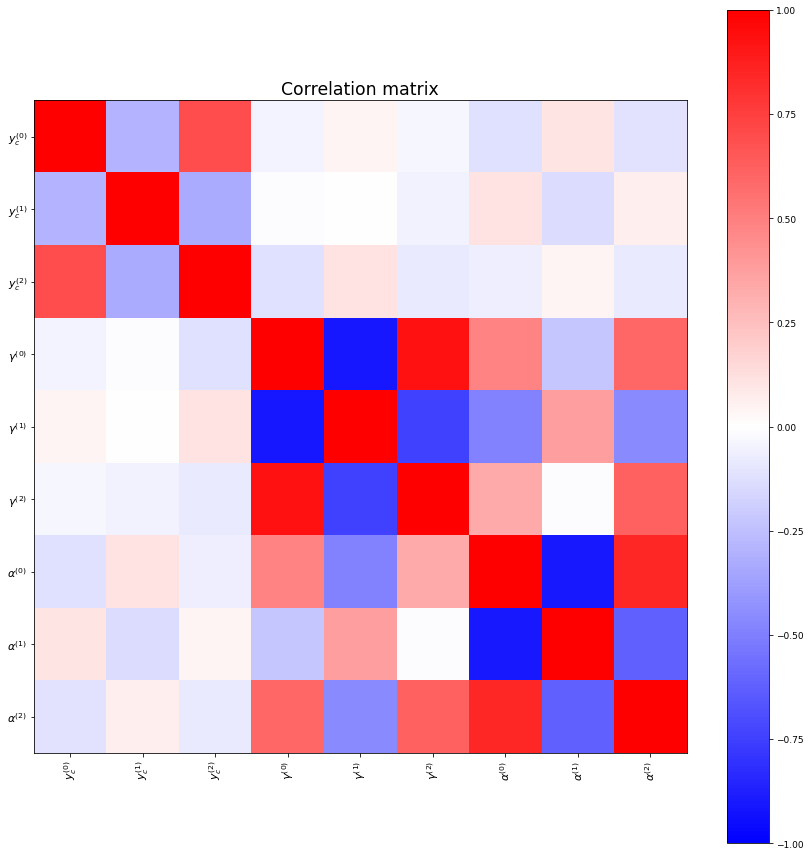

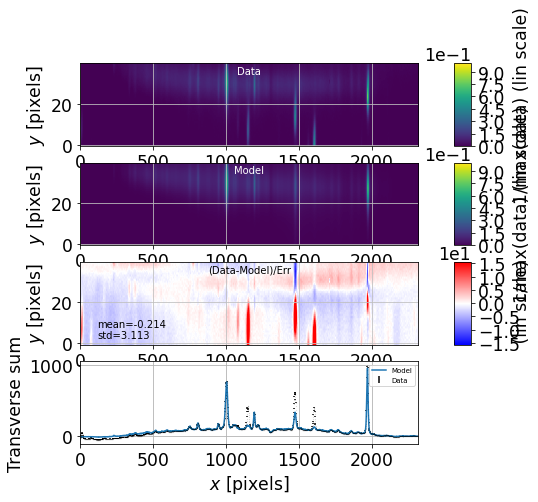

2021-09-23 12:11:23  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
     amplitude       x_c          y_c        ...         Dy         Dy_disp_axis
------------------- ------ ----------------- ... ------------------ ------------
 -8.408429769227016    0.0 97.88178002449632 ... 17.163696049485736          0.0
 -6.484735572578262    1.0 97.87162580125045 ...  17.15354182623986          0.0
-7.5793498161260535    2.0 97.86147615467979 ... 17.143392179669206          0.0
 -8.820150716798379    3.0 97.85133108478435 ... 17.133247109773762          0.0
 -7.195907610336696    4.0  97.8411905915641 ... 17.123106616553514          0.0
 -7.881872774267933    5.0 97.83105467501906 ... 17.112970700008475          0.0
-7.5345349056532385    6.0 97.82092333514922 ...  17.10283936013863          0.0
 -8.725735929557104    7.0 97.81079657195457 ... 17.092712596943983          0.0
 -8.554996082365966    8.0 97.80067438543513 ... 17.08259041

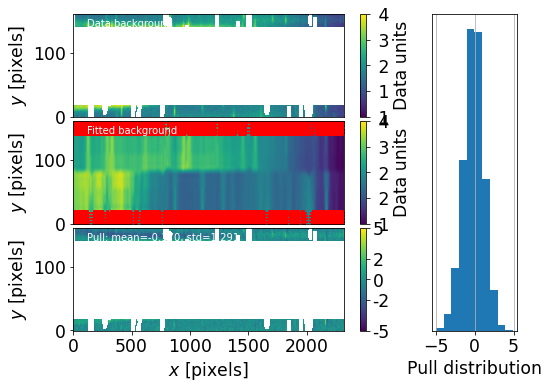

2021-09-23 12:11:37  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.347 ADU/s, RMS=0.256 ADU/s.
2021-09-23 12:11:37  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1150:3467,1687:1848] (size (2317, 161))
	New target position in spectrogram frame: [-851.2427435788763, 80.7189503092236]


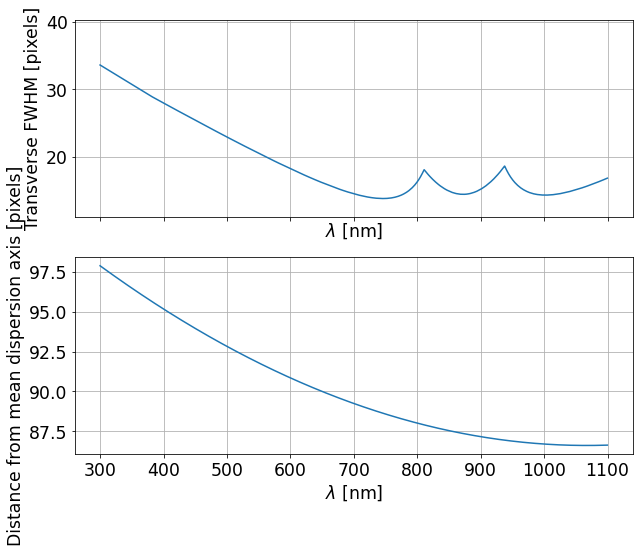

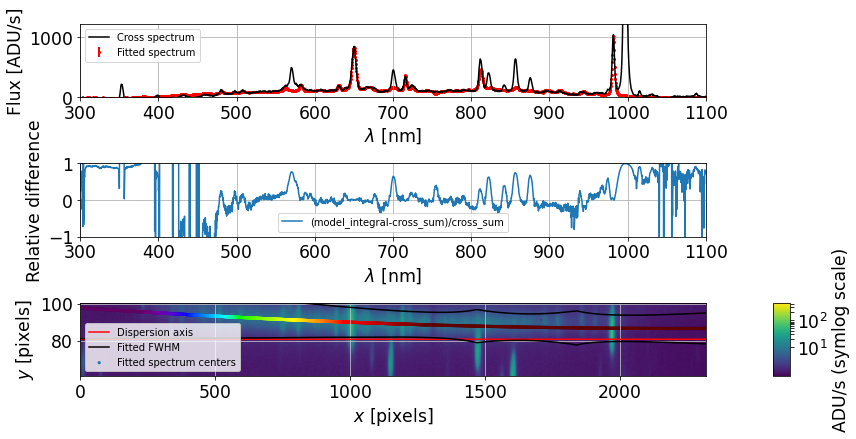

2021-09-23 12:11:40  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


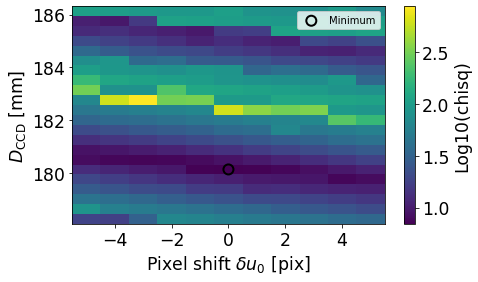

2021-09-23 12:12:12  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.011pix
	D = 180.124 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.5 sigma shift)
2021-09-23 12:12:17  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-09-23 12:17:54  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=3.1097e+06 initial chisq_red=32.735
		 Line search: alpha_min=2.62 iter=0 funcalls=5
	Parameter shifts: [13.30432041 -0.09124266]
	New parameters: [13.30432041 -0.09124266]
	Final cost=1.4016e+06 final chisq_red=14.754 computed in 302.62s
2021-09-23 12:21:58  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.4016e+06 initial chisq_red=14.754
		 Line search: alpha_min=1.62 iter=1 funcalls=5
	Parameter shifts: [ 8.30698617 -0.28159244]
	New parameters: [21.61130658 -0.37283511]
	Final cost=1.1623e+06 final chisq_red=12.235 computed in 244.25s
2021-09-2

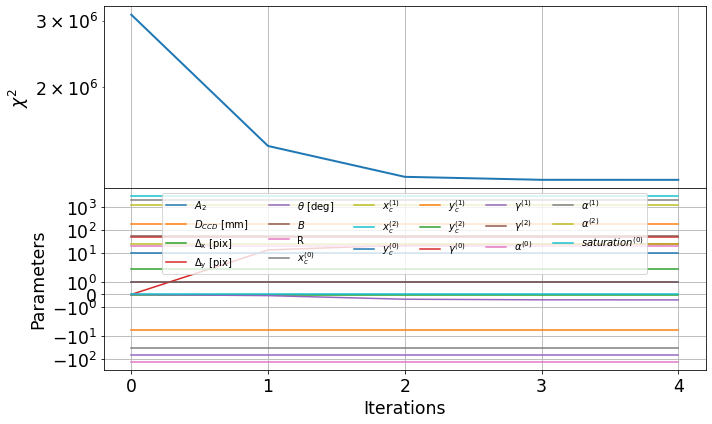

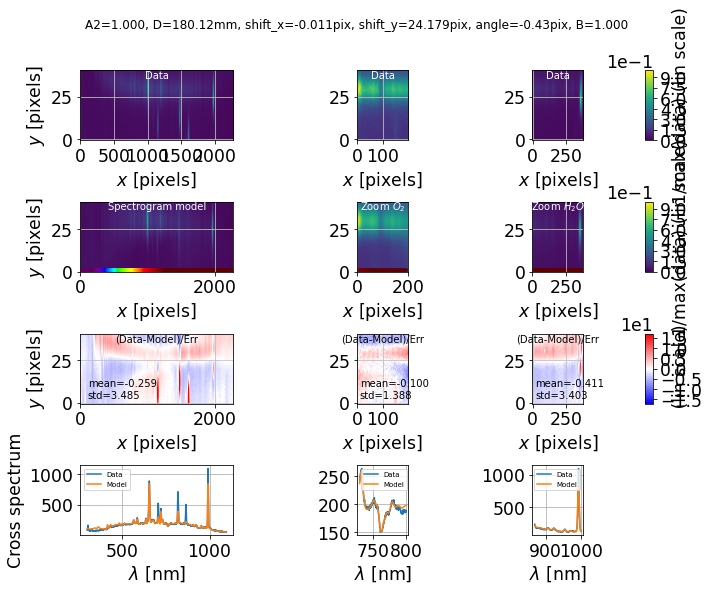

2021-09-23 12:29:55  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure _bestfit.pdf.


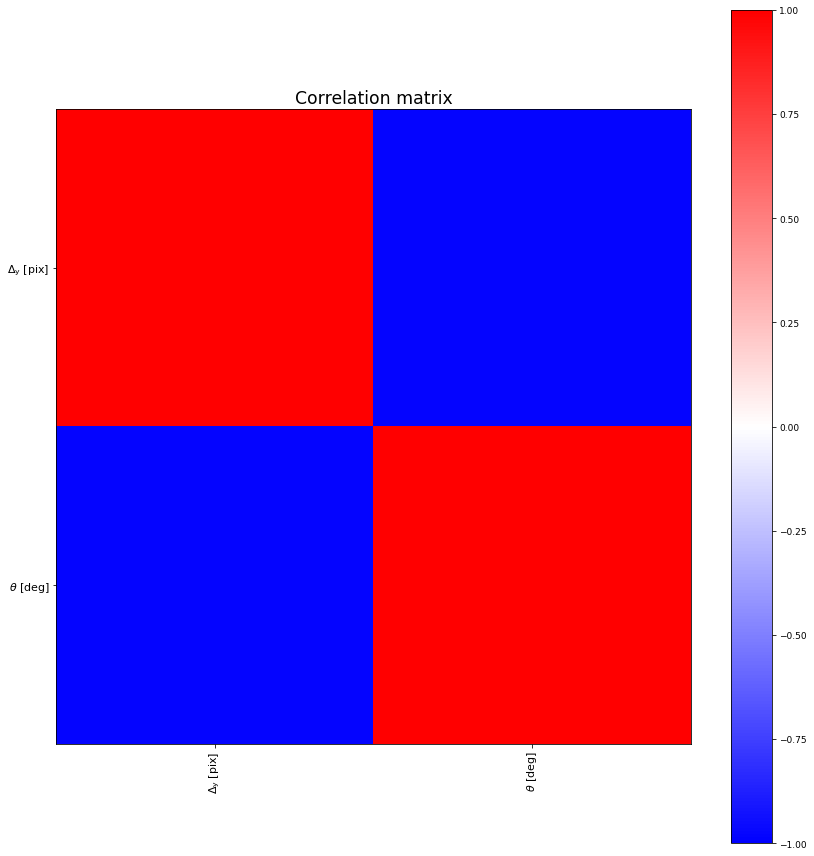

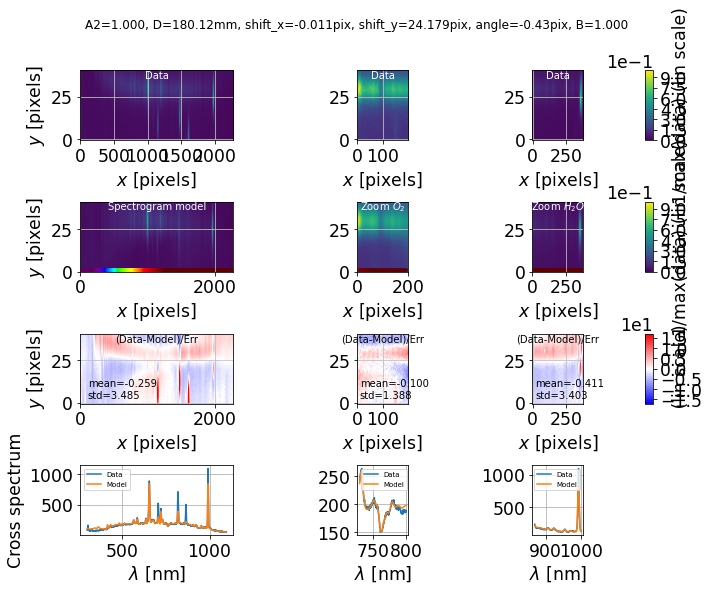

2021-09-23 12:30:30  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure _bestfit.pdf.
2021-09-23 12:30:31  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.80123768e+02 -1.12463961e-02  2.41792840e+01
 -4.25258164e-01  1.00000000e+00 -1.27192765e+02  2.01024222e+03
  1.15800000e+03  2.37618026e-13  9.49389343e+00 -5.62408373e+00
  2.04571890e+00  4.94884854e+01 -6.89289000e+01  5.44280169e+01
  1.92331889e+01 -3.13727432e+01  2.44089368e+01  2.83779256e+03]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-09-23 12:37:17  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.1412e+06 initial chisq_red=12.013
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-4.46206849e-01  1.03626477e-02 -2.02892683e+01 

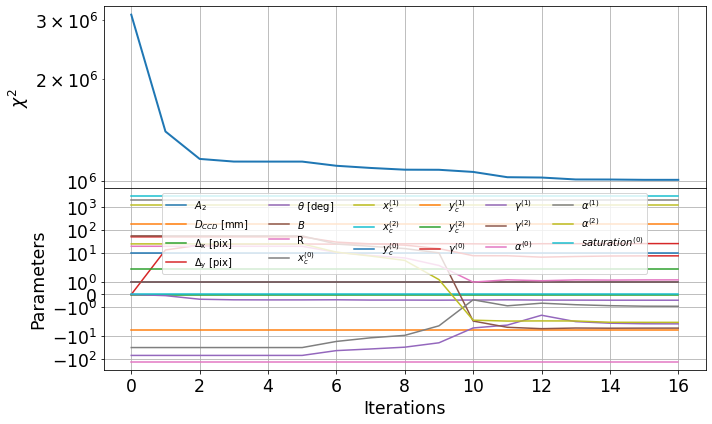

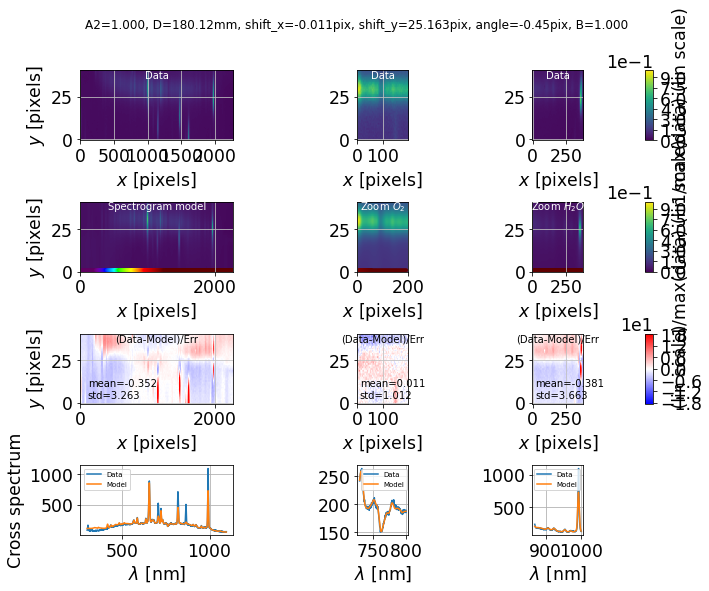

2021-09-23 13:52:52  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure _bestfit.pdf.


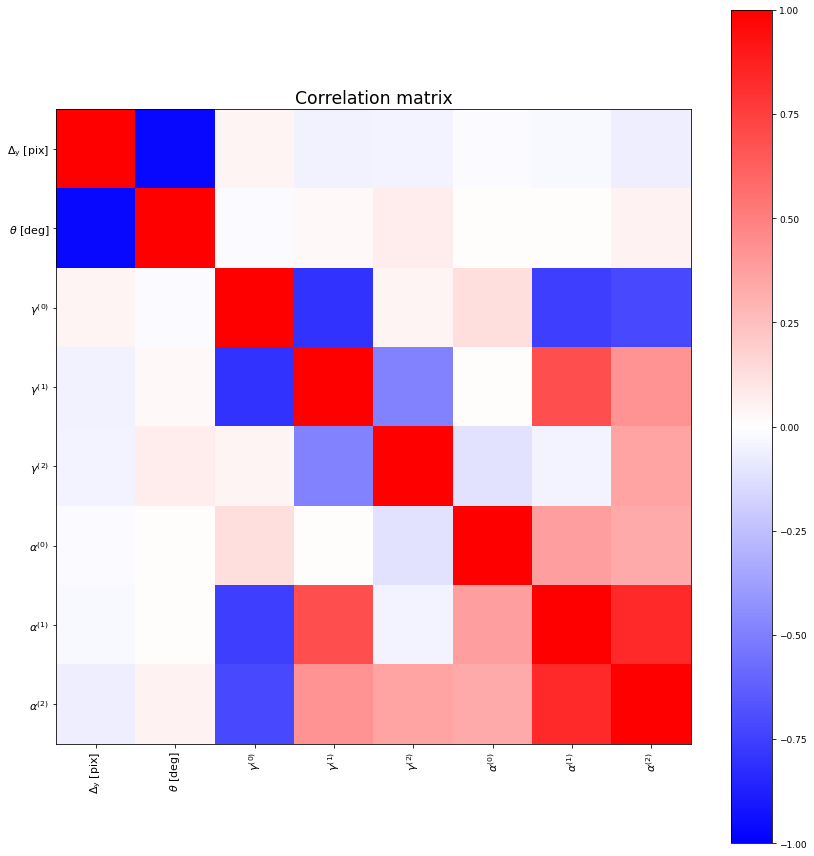

2021-09-23 13:52:55  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
/users/dagoret/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
2021-09-23 13:54:27  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[-2.6261875],
       [-2.626125 ]]), array([5.62893461e-09, 5.62893461e-09]))
           fun: 5.628934605886929e-09
       message: 'Optimization terminated successfully.'
          nfev: 56
           nit: 28
        status: 0
       success: True
             x: array([-2.6261875])
2021-09-23 13:54:27  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 92.47778391838074s


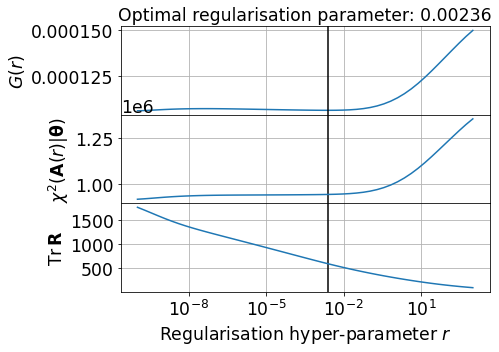

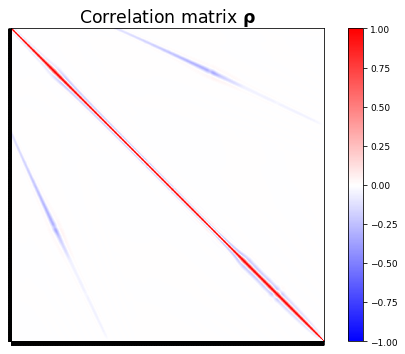

2021-09-23 13:56:36  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 0.0023648984683091482
	Tr(R) = 597.7723110500717
	N_params = 2317
	N_data = 94997 (without mask and outliers)
2021-09-23 13:59:55  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=7.723e+05 initial chisq_red=9.42
		 Line search: alpha_min=0.382 iter=3 funcalls=7
	Parameter shifts: [ 0.08502942 -0.00224199  0.64086249 -0.20589074 -0.46561837  0.02039429
 -0.19565588 -0.44316802]
	New parameters: [25.24803289 -0.45114292  8.01115483 -3.13787489 -4.95362008  1.16184867
 -1.11777332 -2.96377761]
	Final cost=7.7097e+05 final chisq_red=9.4039 computed in 151.64s
2021-09-23 14:02:11  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=7.7097e+05 initial chisq_red=9.4039
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.14692456 -0.00365122 -0.31508024  1.75920204 -1.41317118 -0.01614742
  0.11661743 -0.11414707

2021-09-23 14:42:53  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 15 iterations because the relative change of cost is below ftol=1.0526648209943472e-05.
2021-09-23 14:42:53  spectractor.fit.fitter print_parameter_summary INFO   
	shift_y [pix]: 25.43 +0.01 -0.01
	angle [deg]: -0.4562 +0.0004 -0.0004
	gamma_0: 8.49 +0.02 -0.02
	gamma_1: -2.24 +0.03 -0.03
	gamma_2: -6.47 +0.04 -0.04
	alpha_0: 1.236 +0.003 -0.003
	alpha_1: -1.15 +0.01 -0.01
	alpha_2: -3.43 +0.02 -0.02
	


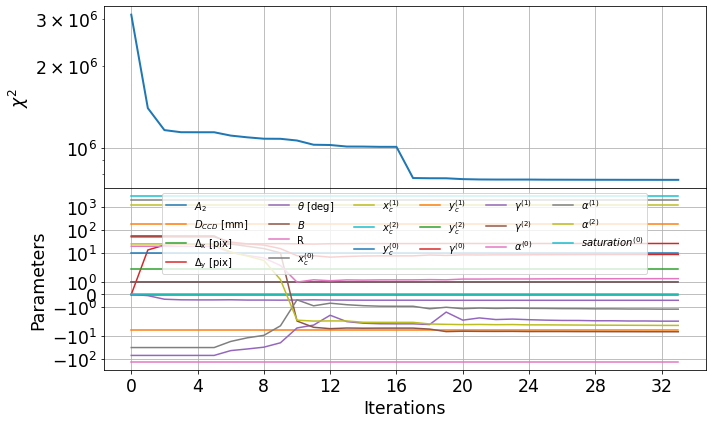

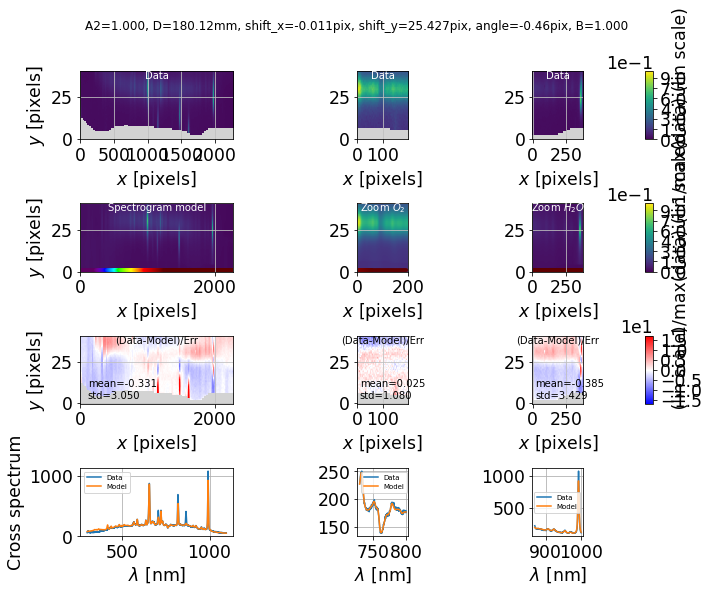

2021-09-23 14:43:05  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure _bestfit.pdf.


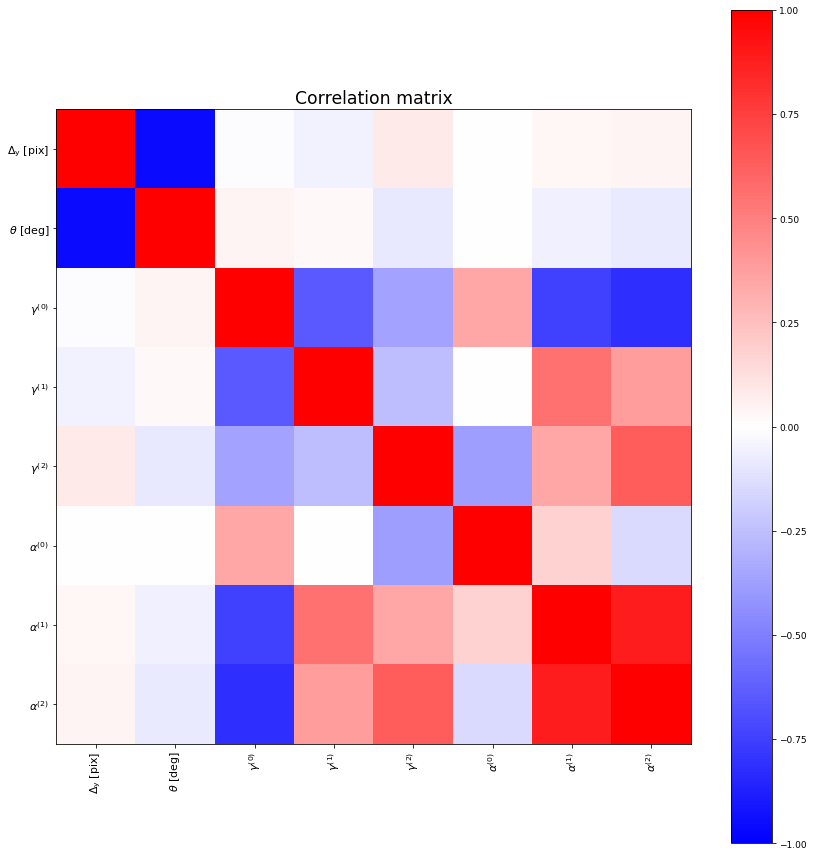

2021-09-23 14:43:07  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [6243, 6244, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 10863, 10864, 10865, 10866, 10867, 10868, 10869, 10870, 10871, 10872, 10873, 10874, 10875, 10876, 10877, 10878, 13181, 13182, 13183, 13184, 13185, 13186, 13187, 13188, 13189, 13190, 13191, 13192, 13193, 13194, 13195, 15046, 15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054, 15055, 15056, 15057, 15499, 15500, 15501, 15502, 15503, 15504, 15505, 15506, 15507, 15508, 15509, 15510, 15511, 15512, 17363, 17364, 17365, 17366, 17367, 17368, 17369, 17370, 17371, 17372, 17373, 17688, 17689, 17690, 17817, 17818, 17819, 17820, 17821, 17822, 17823, 17824, 17825, 17826, 17827, 17828, 19680, 19681, 19682, 19683, 19684, 19685, 19686, 19687, 19688, 19689, 19690, 20004, 20005, 20006, 20007, 20008, 20009, 20135, 20136, 20137, 20138, 20139, 20140, 20141, 20142, 20143, 20144, 2014

In [ ]:
#spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)
spectrum = Spectractor(filename_image, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Remove temporary file

In [ ]:
os.remove(filename_image)